
![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/ocr/BRAND_EXTRACTION.ipynb)

# **Example of usage Spark OCR with Image Brands Extractions**

## 🔎**Colab Setup** 

In [ ]:
import json, os
from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.0.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
! pip install spark-ocr==$OCR_VERSION\+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

In [1]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)



## **🔎Import OCR transformers**

In [2]:
import sparkocr
import sys
from pyspark.sql import SparkSession
from sparkocr import start
import base64
from sparkocr.transformers import *
from pyspark.ml import PipelineModel, Pipeline
from pyspark.sql import functions as F
from pyspark.sql.functions import  col
from sparkocr.enums import *
from termcolor import colored
from sparkocr.utils import display_images, display_image

In [3]:
# Start spark
spark = sparkocr.start(secret=SPARK_OCR_SECRET, 
                       nlp_version=PUBLIC_VERSION
                       )

spark

Spark version: 3.0.2
Spark NLP version: 3.4.4
Spark OCR version: 3.12.0



In [4]:
spark.conf.set("spark.sql.legacy.allowUntypedScalaUDF", True)
print(spark.conf.get("spark.sql.legacy.allowUntypedScalaUDF"))

true


## **🔎Define OCR transformers and pipeline**

In [5]:
# Read binary as image
binary_to_image = BinaryToImage()
binary_to_image.setInputCol("content")
binary_to_image.setOutputCol("image")

# Binarize using adaptive tresholding
binarizer = ImageAdaptiveThresholding()
binarizer.setInputCol("image")
binarizer.setOutputCol("binarized_image")

# Apply morphology operation
operation = ImageMorphologyOperation()
operation.setKernelShape(KernelShape.SQUARE)
operation.setKernelSize(2)
operation.setInputCol("binarized_image")
operation.setOutputCol("opening_image")

# Remove small objects
remove_objects = ImageRemoveObjects()
remove_objects.setInputCol("opening_image")
remove_objects.setOutputCol("corrected_image")
remove_objects.setMinSizeFont(48)

# Run tesseract OCR for corrected image
ocr_corrected = ImageBrandsToText()
ocr_corrected.setInputCol("corrected_image")
ocr_corrected.setOutputCol("image_brands")
ocr_corrected.setIgnoreResolution(False)
ocr_corrected.setOcrParams(["preserve_interword_spaces=1", ])
ocr_corrected.setPageSegMode(PageSegmentationMode.SINGLE_WORD)
ocr_corrected.setBrandsCoords("""
              [
                 {
                    "name": "name",
                    "rectangle": {
                       "x": 249,
                       "y": 158,
                       "width": 204,
                       "height": 23
                    }
                 },
                 {
                    "name": "issue_date",
                    "rectangle": {
                       "x": 639,
                       "y": 156,
                       "width": 129,
                       "height": 20
                    }
                 },
                 {
                    "name": "serial_number",
                    "rectangle": {
                       "x": 570,
                       "y": 339,
                       "width": 188,
                       "height": 33
                    }
                 }
              ]

""")

# OCR pipeline
pipeline = Pipeline(stages=[
    binary_to_image,
    binarizer,
    operation,
    remove_objects,
    ocr_corrected ])


## **🔎Read Image as binary file**

In [6]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/streamlit_notebooks/ocr/data/brand_extraction_2.jpg

In [7]:
image_path = 'brand_extraction_2.jpg'
image_df = spark.read.format("binaryFile").load(image_path)

## **🔎Run OCR pipelines**

In [8]:
ocr_result = pipeline.fit(image_df).transform(image_df).cache()

## **🔎Results**


    Image #0:
    Origin: file:/content/brand_extraction_2.jpg
    Resolution: 96 dpi
    Width: 822 px
    Height: 447 px
    Mode: ImageType.TYPE_BYTE_BINARY
    Number of channels: 1


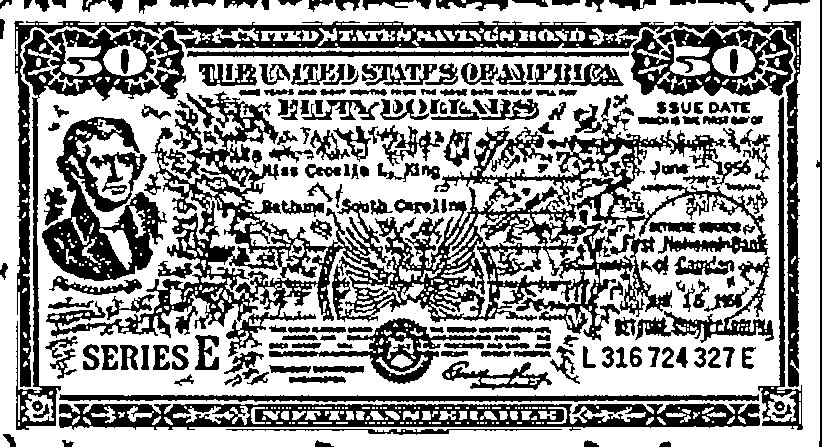

path:
file:/content/brand_extraction_2.jpg
Name:
{Miss Cecelia L, Xing.

Issue Date:
 June 1956 >

Serial Number:
L316 724327E



In [9]:
results = ocr_result.select(col("corrected_image"),col("path"),col("image_brands.name.text").alias("name"),col("image_brands.issue_date.text").alias("issue_date"),\
                            col("image_brands.serial_number.text").alias("serial_number")).collect()
for row in results:
    display_image(row.corrected_image)
    print(colored("path:\n%s" % row.path, "red"))
    print("Name:\n%s" % row.name)
    print("Issue Date:\n%s" % row.issue_date)
    print("Serial Number:\n%s" % row.serial_number)
    